In [1]:
import warnings
warnings.filterwarnings('ignore')

%pip install tf_keras_vis
%pip install tflite-support

# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [14]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import (
    Resizing, Rescaling,
    RandomFlip, RandomRotation, RandomZoom,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

from tflite_support.metadata_writers import image_classifier, writer_utils

In [3]:
def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])
        
    return pd.DataFrame(data, columns = ["path", "label"])

In [4]:
# If you're using Google Colab, you need to upload your data to Google Drive.
# Then, run the following code to mount your Google Drive and access your files in Colab.

#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# Configuration
dataset_path = "dataset"
batch_size = 32
img_size = (224, 224)
seed = 123

# Chargement du dataset brut
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Affichage des noms de classes détectées
class_names = raw_train_ds.class_names
print("Classes détectées :", class_names)

# Prétraitement MobileNetV2
train_ds = raw_train_ds.map(lambda x, y: (preprocess_input(x), y)).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = raw_val_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 300 files belonging to 5 classes.
Using 240 files for training.
Found 300 files belonging to 5 classes.
Using 60 files for validation.
Classes détectées : ['bieres', 'champagne', 'sans_alcool', 'spiritueux', 'vins']


**TODO**: Display some images of your dataset

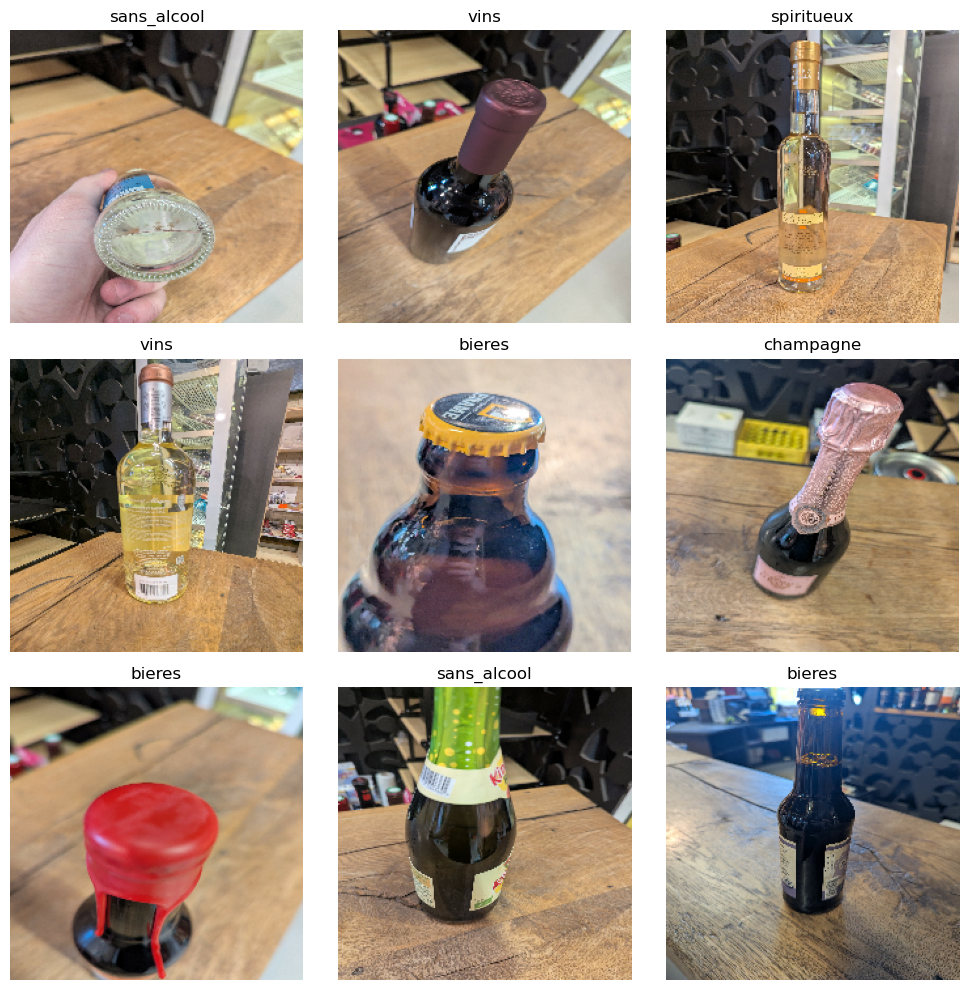

In [6]:
# Affichage de 9 images aléatoires avec leur étiquette
num_images = 9
image_batch, label_batch = next(iter(raw_train_ds))

plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Explore your dataset

**TODO**: count the number of examples per classes and plot an histogram of it

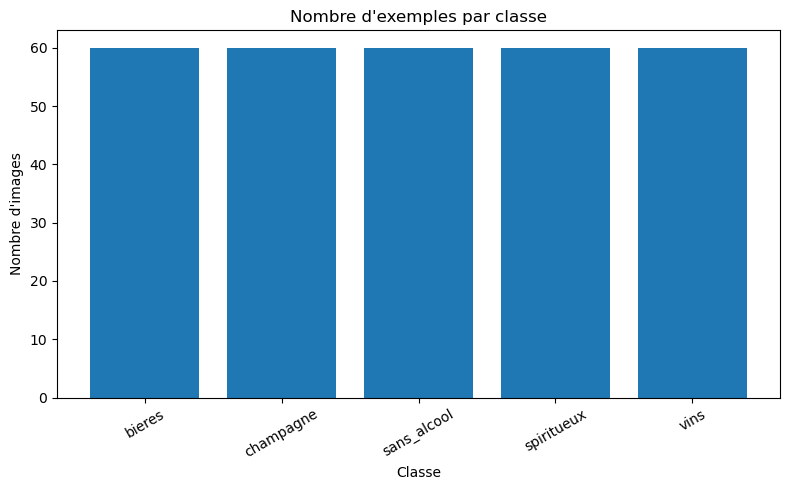

In [7]:
# Compter les images par classe dans le dossier dataset
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Affichage de l'histogramme
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Nombre d'exemples par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Preprocessing steps

In [8]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation
    
    RandomFlip("horizontal"),      # retournement horizontal aléatoire
    RandomRotation(0.1),           # rotation aléatoire de ±10%
    RandomZoom(0.1),               # zoom in/out aléatoire
])

def open_image(path):
    with PIL.Image.open(path) as image:
        image = image.convert("RGB")  # Assure 3 canaux
        image_array = np.asarray(image)
        processed_image = image_preprocesses(image_array)
    return processed_image

def open_images(paths):
    return tf.stack([
        open_image(path) for path in paths
    ])

def augment_images(images):
    return image_augmentations(images)

**TODO**: plot examples of preprocessed and augmented images

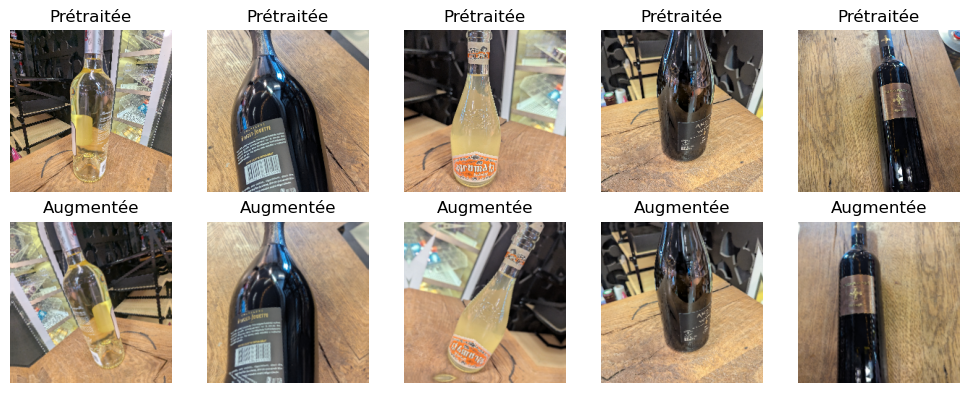

In [9]:
# Sélection de quelques chemins d’images depuis le dataframe (si vous l'avez créé)
train_df = create_dataframe_from_directories(dataset_path)
sample_paths = train_df.sample(5, random_state=seed)["path"].tolist()

# Chargement et prétraitement des images
original_images = open_images(sample_paths)

# Augmentation des images
augmented_images = augment_images(original_images)

# Affichage
plt.figure(figsize=(10, 4))
for i in range(len(sample_paths)):
    # Image originale
    ax = plt.subplot(2, len(sample_paths), i + 1)
    plt.imshow(original_images[i].numpy())
    plt.title("Prétraitée")
    plt.axis("off")
    
    # Image augmentée
    ax = plt.subplot(2, len(sample_paths), i + 1 + len(sample_paths))
    plt.imshow(augmented_images[i].numpy())
    plt.title("Augmentée")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Define model

In [10]:
def get_model(num_classes=5):
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    # Geler les couches du modèle de base
    base_model.trainable = False

    # Ajout de nouvelles couches
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)

    model.compile(
        optimizer=RMSprop(learning_rate=0.0001),
        loss=SparseCategoricalCrossentropy(),
        metrics=['acc']
    )

    return model

In [11]:
get_model().summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [12]:
# ------------------------------------------------------------------
# 0. Table de correspondance : étiquette  ->  indice numérique
class_to_idx = {name: i for i, name in enumerate(class_names)}

# 1. Chemins d’images et labels
paths  = train_df["path"].values
labels = train_df["label"].map(class_to_idx).values

# 2. Split définitif : 90 % CV, 10 % test
SEED       = 123
train_paths, test_paths, train_labels, test_labels = train_test_split(
    paths, labels,
    test_size=0.10,
    stratify=labels,
    random_state=SEED
)

# 3. Fonction TF « pure »
IMG_HEIGHT, IMG_WIDTH = 224, 224
def path_to_tensor(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32)
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    return img, label

# 4. Hyper-paramètres
N_FOLDS    = 5
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

def get_augmentations():
    return tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ], name="data_augmentation")

# ---------- FACTORISATION pour éviter la duplication ---------------
def build_dataset(paths, labels, batch_size=32,
                  training=False, augmentations=None):
    ds = (tf.data.Dataset.from_tensor_slices((paths, labels))
            .map(path_to_tensor, num_parallel_calls=AUTOTUNE))
    if training and augmentations is not None:
        ds = ds.shuffle(len(paths), seed=SEED) \
               .batch(batch_size, drop_remainder=True) \
               .map(lambda x, y: (augmentations(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.batch(batch_size)
    ds = ds.map(lambda x, y: (preprocess_input(x), y),
                num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return ds
# -------------------------------------------------------------------

# 5. Cross-validation sur le *train*
skf      = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
results  = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(train_paths, train_labels), 1):
    print(f"\n===== FOLD {fold}/{N_FOLDS} =====")
    aug = get_augmentations()

    train_ds = build_dataset(train_paths[tr_idx], train_labels[tr_idx],
                             batch_size=BATCH_SIZE, training=True,
                             augmentations=aug)

    val_ds   = build_dataset(train_paths[va_idx], train_labels[va_idx],
                             batch_size=BATCH_SIZE)

    model = get_model(num_classes=len(class_names))
    early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    # ---- on garde history pour la courbe loss ----
    history = model.fit(train_ds,
                        epochs=30,
                        validation_data=val_ds,
                        callbacks=[early],
                        verbose=2)

    _, val_acc = model.evaluate(val_ds, verbose=0)
    print(f"✔️  Fold {fold} – val_acc : {val_acc:.3f}")
    results.append(val_acc)

print("\n=== RÉSUMÉ DES FOLDS ===")
for i, acc in enumerate(results, 1):
    print(f"Fold {i} : {acc:.3f}")
print(f"Précision moyenne : {np.mean(results):.3f} ± {np.std(results):.3f}")

# 6. Jeu de test
test_ds = build_dataset(test_paths, test_labels, batch_size=BATCH_SIZE)



===== FOLD 1/5 =====
Epoch 1/30
6/6 - 12s - 2s/step - acc: 0.1875 - loss: 1.9309 - val_acc: 0.3148 - val_loss: 1.6082
Epoch 2/30
6/6 - 6s - 942ms/step - acc: 0.2292 - loss: 1.8163 - val_acc: 0.2407 - val_loss: 1.5772
Epoch 3/30
6/6 - 7s - 1s/step - acc: 0.2812 - loss: 1.6125 - val_acc: 0.3148 - val_loss: 1.5374
Epoch 4/30
6/6 - 7s - 1s/step - acc: 0.3229 - loss: 1.5650 - val_acc: 0.3704 - val_loss: 1.4846
Epoch 5/30
6/6 - 7s - 1s/step - acc: 0.3385 - loss: 1.5220 - val_acc: 0.3889 - val_loss: 1.4509
Epoch 6/30
6/6 - 7s - 1s/step - acc: 0.3542 - loss: 1.4680 - val_acc: 0.4259 - val_loss: 1.4195
Epoch 7/30
6/6 - 7s - 1s/step - acc: 0.3646 - loss: 1.4251 - val_acc: 0.4444 - val_loss: 1.3501
Epoch 8/30
6/6 - 7s - 1s/step - acc: 0.4167 - loss: 1.3774 - val_acc: 0.4815 - val_loss: 1.3678
Epoch 9/30
6/6 - 7s - 1s/step - acc: 0.4792 - loss: 1.3423 - val_acc: 0.4630 - val_loss: 1.3090
Epoch 10/30
6/6 - 8s - 1s/step - acc: 0.4271 - loss: 1.3162 - val_acc: 0.4815 - val_loss: 1.2653
Epoch 11/30
6

Epoch 25/30
6/6 - 8s - 1s/step - acc: 0.7188 - loss: 0.8023 - val_acc: 0.5185 - val_loss: 1.2196
Epoch 26/30
6/6 - 9s - 1s/step - acc: 0.7240 - loss: 0.7780 - val_acc: 0.5556 - val_loss: 1.2092
Epoch 27/30
6/6 - 10s - 2s/step - acc: 0.7344 - loss: 0.8187 - val_acc: 0.5370 - val_loss: 1.2014
Epoch 28/30
6/6 - 7s - 1s/step - acc: 0.8177 - loss: 0.6918 - val_acc: 0.5000 - val_loss: 1.2207
Epoch 29/30
6/6 - 8s - 1s/step - acc: 0.7552 - loss: 0.7371 - val_acc: 0.5185 - val_loss: 1.1854
Epoch 30/30
6/6 - 10s - 2s/step - acc: 0.7760 - loss: 0.7360 - val_acc: 0.5370 - val_loss: 1.1856
✔️  Fold 3 – val_acc : 0.519

===== FOLD 4/5 =====
Epoch 1/30
6/6 - 13s - 2s/step - acc: 0.2344 - loss: 1.7304 - val_acc: 0.2037 - val_loss: 1.6562
Epoch 2/30
6/6 - 8s - 1s/step - acc: 0.2812 - loss: 1.6400 - val_acc: 0.2407 - val_loss: 1.6044
Epoch 3/30
6/6 - 8s - 1s/step - acc: 0.3229 - loss: 1.5450 - val_acc: 0.2593 - val_loss: 1.5603
Epoch 4/30
6/6 - 7s - 1s/step - acc: 0.3646 - loss: 1.4855 - val_acc: 0.3148

# Results

**TODO**: plot the results from your crossvalidation

F1-score (pondéré) : 0.694


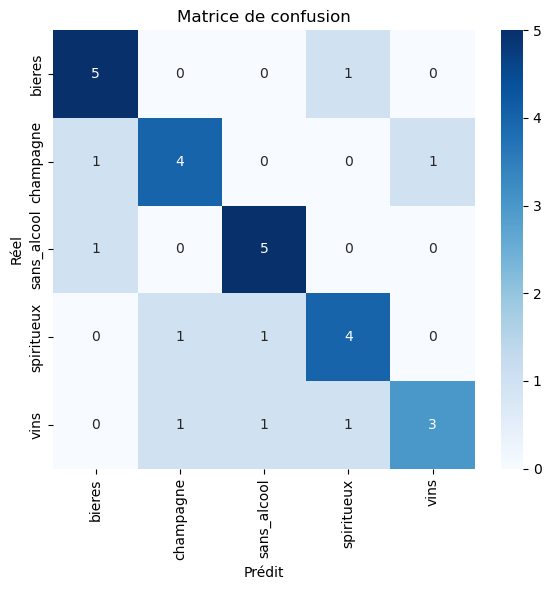

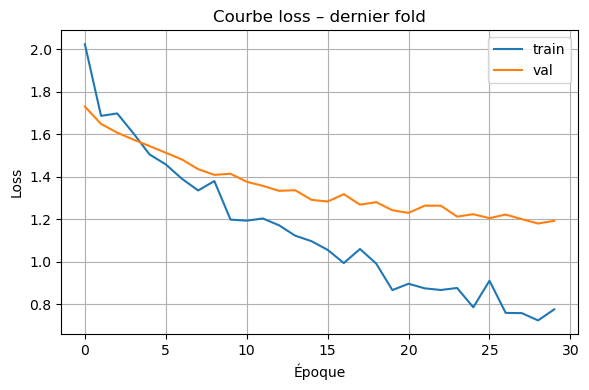

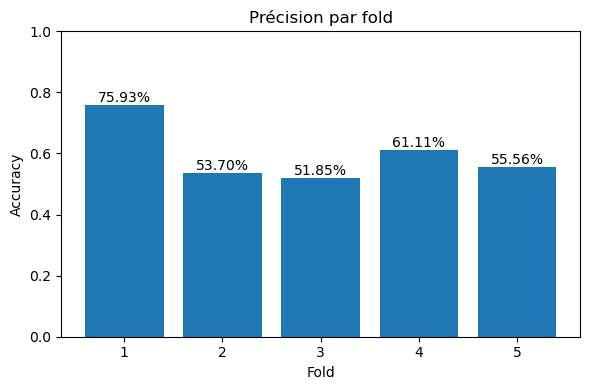

Précision moyenne : 0.596 ± 0.087


In [15]:
y_true = test_labels
y_pred = np.argmax(model.predict(test_ds, verbose=0), axis=1)

# F1-score pondéré
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-score (pondéré) : {f1:.3f}")

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

# Courbe des pertes (dernier fold)
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'],     label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.title('Courbe loss – dernier fold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


folds = np.arange(1, len(results) + 1)

plt.figure(figsize=(6, 4))
plt.bar(folds, results)
plt.ylim(0, 1)
plt.title("Précision par fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
for x, y in zip(folds, results):
    plt.text(x, y + 0.01, f"{y:.2%}", ha='center')  # affiche la valeur au-dessus de chaque barre
plt.tight_layout()
plt.show()

print(f"Précision moyenne : {np.mean(results):.3f} ± {np.std(results):.3f}")


## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

Epoch 1/30

Epoch 1: val_acc improved from -inf to 0.31481, saving model to best_model.h5


6/6 - 11s - 2s/step - acc: 0.2656 - loss: 1.7957 - val_acc: 0.3148 - val_loss: 1.5100
Epoch 2/30

Epoch 2: val_acc improved from 0.31481 to 0.37037, saving model to best_model.h5


6/6 - 7s - 1s/step - acc: 0.2708 - loss: 1.6346 - val_acc: 0.3704 - val_loss: 1.4768
Epoch 3/30

Epoch 3: val_acc improved from 0.37037 to 0.38889, saving model to best_model.h5


6/6 - 8s - 1s/step - acc: 0.3594 - loss: 1.5941 - val_acc: 0.3889 - val_loss: 1.4426
Epoch 4/30

Epoch 4: val_acc improved from 0.38889 to 0.44444, saving model to best_model.h5


6/6 - 8s - 1s/step - acc: 0.3490 - loss: 1.5009 - val_acc: 0.4444 - val_loss: 1.4111
Epoch 5/30

Epoch 5: val_acc improved from 0.44444 to 0.46296, saving model to best_model.h5


6/6 - 8s - 1s/step - acc: 0.4115 - loss: 1.4149 - val_acc: 0.4630 - val_loss: 1.3909
Epoch 6/30

Epoch 6: val_acc improved from 0.46296 to 0.48148, saving model to best_model.h5


6/6 - 8s - 1s/step - acc: 0.4219 - loss: 1.3772 - val_acc: 0.4815 - val_loss: 1.3755
Epoch 7/30

Epoch 7: val_acc did not improve from 0.48148
6/6 - 8s - 1s/step - acc: 0.4167 - loss: 1.3943 - val_acc: 0.4815 - val_loss: 1.3496
Epoch 8/30

Epoch 8: val_acc improved from 0.48148 to 0.51852, saving model to best_model.h5


6/6 - 9s - 2s/step - acc: 0.4948 - loss: 1.2964 - val_acc: 0.5185 - val_loss: 1.3229
Epoch 9/30

Epoch 9: val_acc improved from 0.51852 to 0.55556, saving model to best_model.h5


6/6 - 9s - 2s/step - acc: 0.5000 - loss: 1.3219 - val_acc: 0.5556 - val_loss: 1.3033
Epoch 10/30

Epoch 10: val_acc did not improve from 0.55556
6/6 - 10s - 2s/step - acc: 0.4635 - loss: 1.2828 - val_acc: 0.4815 - val_loss: 1.3138
Epoch 11/30

Epoch 11: val_acc improved from 0.55556 to 0.57407, saving model to best_model.h5


6/6 - 9s - 2s/step - acc: 0.4948 - loss: 1.2476 - val_acc: 0.5741 - val_loss: 1.2664
Epoch 12/30

Epoch 12: val_acc did not improve from 0.57407
6/6 - 8s - 1s/step - acc: 0.5781 - loss: 1.1513 - val_acc: 0.5370 - val_loss: 1.2667
Epoch 13/30

Epoch 13: val_acc improved from 0.57407 to 0.61111, saving model to best_model.h5


6/6 - 9s - 1s/step - acc: 0.5417 - loss: 1.1688 - val_acc: 0.6111 - val_loss: 1.2517
Epoch 14/30

Epoch 14: val_acc did not improve from 0.61111
6/6 - 10s - 2s/step - acc: 0.5885 - loss: 1.0885 - val_acc: 0.6111 - val_loss: 1.2319
Epoch 15/30

Epoch 15: val_acc did not improve from 0.61111
6/6 - 9s - 2s/step - acc: 0.6458 - loss: 1.0325 - val_acc: 0.6111 - val_loss: 1.2300
Epoch 16/30

Epoch 16: val_acc improved from 0.61111 to 0.62963, saving model to best_model.h5


6/6 - 9s - 2s/step - acc: 0.5729 - loss: 1.0628 - val_acc: 0.6296 - val_loss: 1.2285
Epoch 17/30

Epoch 17: val_acc did not improve from 0.62963
6/6 - 11s - 2s/step - acc: 0.6146 - loss: 1.0062 - val_acc: 0.6111 - val_loss: 1.2191
Epoch 18/30

Epoch 18: val_acc did not improve from 0.62963
6/6 - 16s - 3s/step - acc: 0.6771 - loss: 1.0012 - val_acc: 0.6111 - val_loss: 1.2405
Epoch 19/30

Epoch 19: val_acc did not improve from 0.62963
6/6 - 9s - 1s/step - acc: 0.6667 - loss: 0.9716 - val_acc: 0.5926 - val_loss: 1.2268
Epoch 20/30

Epoch 20: val_acc did not improve from 0.62963
6/6 - 9s - 2s/step - acc: 0.6875 - loss: 0.9265 - val_acc: 0.5926 - val_loss: 1.2071
Epoch 21/30

Epoch 21: val_acc did not improve from 0.62963
6/6 - 9s - 1s/step - acc: 0.6979 - loss: 0.9716 - val_acc: 0.5741 - val_loss: 1.2071
Epoch 22/30

Epoch 22: val_acc did not improve from 0.62963
6/6 - 9s - 1s/step - acc: 0.6979 - loss: 0.8865 - val_acc: 0.5926 - val_loss: 1.1838
Epoch 23/30

Epoch 23: val_acc did not impr

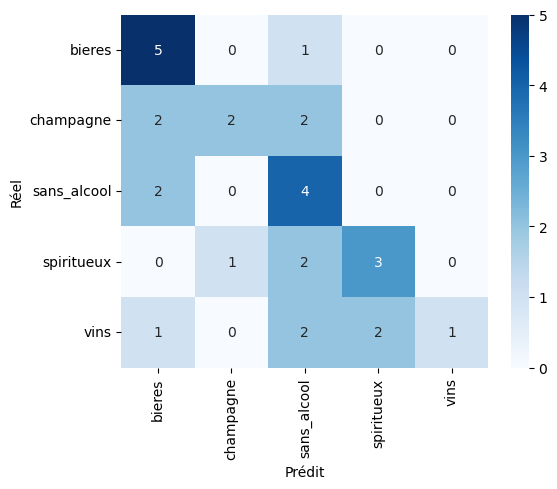

In [16]:
# -------- 1) (ré)entrainement complet + sauvegarde du meilleur poids --------
final_model = get_model(num_classes=len(class_names))
ckpt = tf.keras.callbacks.ModelCheckpoint("best_model.h5",
                                          monitor="val_acc",
                                          mode="max",
                                          save_best_only=True,
                                          verbose=1)
es   = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

history = final_model.fit(train_ds,
                          epochs=30,
                          validation_data=val_ds,
                          callbacks=[ckpt, es],
                          verbose=2)

best_model = tf.keras.models.load_model("best_model.h5", compile=False)
best_model.compile(optimizer="adam",
                   loss=SparseCategoricalCrossentropy(),
                   metrics=["acc"])

# -------- 2) Évaluation sur le test set --------
y_true = np.concatenate([y for _, y in test_ds])
y_prob = best_model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Prédit"); plt.ylabel("Réel"); plt.tight_layout(); plt.show()


### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

Found 300 files belonging to 5 classes.
101 images mal classées


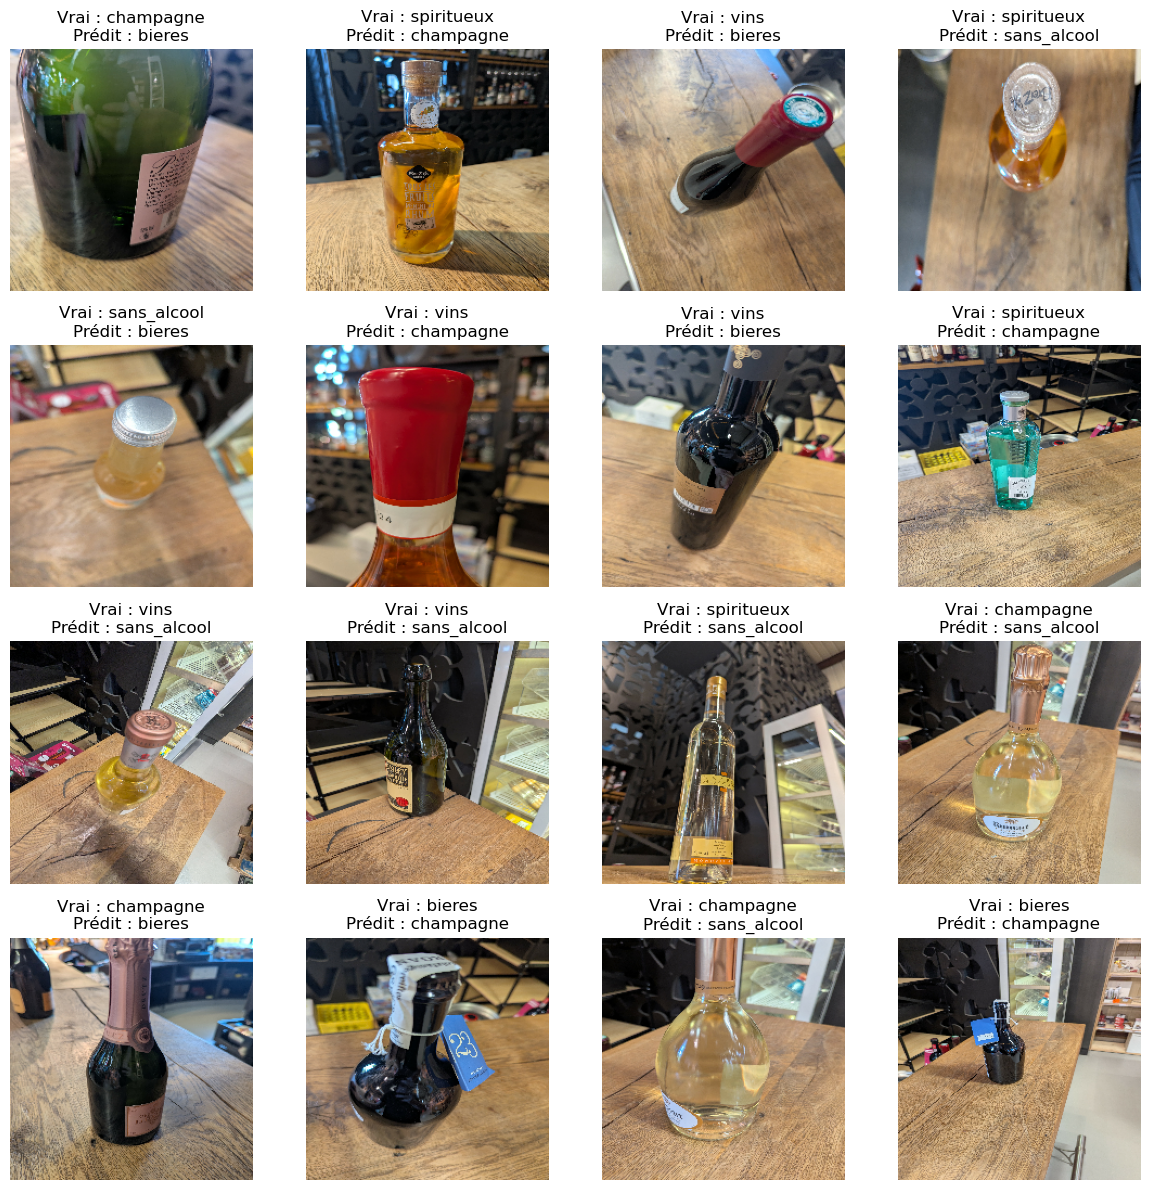

In [17]:
# Récupération des images d'origine (non pré-traitées) + vrais labels
orig_images, y_true_full = [], []
for batch_x, batch_y in tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        image_size=img_size,
        batch_size=1,
        shuffle=False):
    orig_images.append(batch_x[0].numpy().astype("uint8"))
    y_true_full.append(batch_y[0].numpy())
orig_images = np.array(orig_images)
y_true_full = np.array(y_true_full)

# Prédictions
imgs_preproc = preprocess_input(orig_images.copy())
y_pred_full  = np.argmax(best_model.predict(imgs_preproc, batch_size=batch_size, verbose=0), axis=1)

# Indices des erreurs
mis_idx = np.where(y_true_full != y_pred_full)[0]
print(f"{len(mis_idx)} images mal classées")

# Affichage
k = min(16, len(mis_idx))
sample_idx = np.random.choice(mis_idx, k, replace=False)
plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_idx):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(orig_images[idx])
    plt.title(f"Vrai : {class_names[y_true_full[idx]]}\nPrédit : {class_names[y_pred_full[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

In [ ]:
from matplotlib import cm
# ---------- paramètres visuels ----------
NB_PER_CLASS = 6               # images par classe
CELL_W, CELL_H = 4, 4          # taille de cellule en pouces (figsize)
DPI           = 150            # résolution finale
ALPHA         = 0.45           # transparence de la heat-map
SEED          = 123            # reproductibilité

# ---------- modèle à expliquer ----------
vis_model = tf.keras.models.clone_model(best_model)
vis_model.set_weights(best_model.get_weights())

gradcam = GradcamPlusPlus(
    vis_model,
    model_modifier=ReplaceToLinear(),
    clone=False
)

# ---------- figure ----------
fig, axs = plt.subplots(
    NB_PER_CLASS, len(class_names),
    figsize=(len(class_names)*CELL_W, NB_PER_CLASS*CELL_H),
    dpi=DPI
)
plt.subplots_adjust(hspace=.25, wspace=.05)

rng = np.random.default_rng(SEED)
for col, cls in enumerate(class_names):
    rows_cls = train_df[train_df.label == cls]

    # Sélection aléatoire mais déterministe
    sample_rows = rows_cls.sample(
        n=min(NB_PER_CLASS, len(rows_cls)),
        random_state=SEED
    )

    # Titre de la colonne
    axs[0, col].set_title(cls, fontsize=18, fontweight='bold')

    for row, (_, sample) in enumerate(sample_rows.iterrows()):
        # ----- image d’origine -------------------------------------------------
        img_rgb = np.asarray(PIL.Image.open(sample.path).convert('RGB'))
        H, W, _ = img_rgb.shape

        # ----- image pour le modèle -------------------------------------------
        img_tf = open_image(sample.path) * 255.          # tensor 0-255 float32
        img_tf = tf.expand_dims(img_tf, 0)               # batch dim
        img_tf = preprocess_input(img_tf)                # MobileNetV2 prep

        pred    = vis_model(img_tf, training=False)
        pred_id = int(tf.argmax(pred[0]))

        # ----- CAM (224×224) -> (H×W) avec tf.image.resize ---------------------
        cam_small = gradcam(CategoricalScore(pred_id),
                            img_tf,
                            penultimate_layer=-1)[0]      # shape (224,224)
        cam_resized = tf.image.resize(cam_small[..., np.newaxis],
                                      size=(H, W),
                                      method='bilinear'
                        ).numpy().squeeze()               # shape (H,W)

        heat = cm.jet(cam_resized)[..., :3]               # 0-1 RGB

        # ----- overlay et affichage -------------------------------------------
        ax = axs[row, col]
        ax.imshow(img_rgb/255.)
        ax.imshow(heat, alpha=ALPHA)
        ax.axis('off')

        if row >= NB_PER_CLASS-1:
            break

# Masquer les cases vides éventuelles
for ax in axs.flatten():
    if not ax.has_data():
        ax.axis('off')

plt.show()


### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

In [ ]:
# Grad-CAM sur k images mal classées, affichage 4 par ligne
k = 12                                   # nombre d’images à afficher
sample_idx = np.random.choice(mis_idx, k, replace=False)

n_cols = 4
n_rows = int(np.ceil(k / n_cols))
fig, axs = plt.subplots(n_rows, n_cols,
                        figsize=(n_cols * 4, n_rows * 4))

for pos, idx in enumerate(sample_idx):
    r, c = divmod(pos, n_cols)
    ax   = axs[r, c]
    
    img   = orig_images[idx] / 255.0
    score = CategoricalScore(y_pred_full[idx])
    cam   = gradcam(score, img)[0]
    heat  = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax.imshow(img)
    ax.imshow(heat, alpha=0.5)
    ax.set_title(f"Vrai : {class_names[y_true_full[idx]]}\nPrédit : {class_names[y_pred_full[idx]]}",
                 fontsize=16)
    ax.axis("off")

# Masque les cases vides éventuelles
for rem in range(pos + 1, n_rows * n_cols):
    fig.axes[rem].axis("off")

plt.tight_layout()
plt.show()


**TODO**: try to determine what caused the misclassifcations and what you can do about it

## Analyse des erreurs de classification et pistes d’amélioration

### Constat via Grad-CAM
- Le réseau se focalise souvent sur l’arrière-plan (table, billets, étagères) plutôt que sur la bouteille ou son étiquette – signal visuel pauvre.
- Les classes **champagne**, **vins** et **spiritueux** partagent des formes/couleurs similaires (verre transparent + liquide ambré), d’où des confusions fréquentes.
- Certaines photos sont floues, mal cadrées ou sous-exposées : la zone pertinente est trop petite ou cachée ; le modèle n’apprend pas les motifs clés.

### Modèle entraîné uniquement sur les couches de tête
- Les poids d’ImageNet restent gelés et pas adaptés au domaine spécifique.

---

## Actions possibles

### 1. Collecte / équilibrage du dataset
- Ajouter davantage d’images par classe (étiquettes visibles, angles variés).
- Équilibrer les effectifs pour réduire le biais vers les classes majoritaires.

### 2. Nettoyage & pré-traitement
- Recadrer automatiquement ou manuellement autour de la bouteille (segmentation ou détection d’objet).
- Supprimer les images floues, sous-exposées ou avec un arrière-plan dominant.

### 3. Augmentations ciblées
- Utiliser **RandomBrightnessContrast**, **RandomCrop**, **RandomHue** pour varier l’éclairage et inciter le modèle à se concentrer sur la forme.
- Appliquer **RandomRotation(0.2)** et **RandomZoom(0.2)** pour couvrir davantage d’angles.

### 4. Fine-tuning plus profond
- Dégeler progressivement les derniers blocs de **MobileNet V2** (environ 3–4 derniers), puis ré-entraîner avec un **learning rate faible (1e‑5)**.
- Envisager un modèle compact mais entièrement affiné comme **EfficientNet‑B0**.

### 5. Pondération des classes / Focal Loss
- Utiliser `class_weight` ou une **focal loss** pour pénaliser les erreurs sur les classes minoritaires.

### 6. Validation plus stricte
- Mettre en place un **vrai dossier test indépendant** (différent du même shooting) pour éviter les fuites de données et obtenir une meilleure estimation de généralisation.

### 7. Index textuels (OCR)
- Extraire et reconnaître le texte des étiquettes, puis fusionner avec les données visuelles (approche multimodale) pour mieux distinguer champagne et vin.

---

## Priorité recommandée
1. Étapes **1 → 4** : collecte + nettoyage + fine‑tuning partiel  
2. Puis ajouter les **pondérations de classes** et **validation stricte**

Ces étapes devraient déjà permettre de réduire significativement le taux d’erreur.


**TODO**: Export file

In [ ]:
# Task Library expects label files that are in the same format as the one below.
LABEL_FILE = "labels.txt"
SAVE_TO_PATH = "mobilenet_quant.tflite"

# Create the labels file
with open(LABEL_FILE, 'w') as label_file:
    for label in class_names: # /!\ class_names variable must contains the names of the labels you have.
        label_file.write("{}\n".format(label))

tflite_model = tf.lite.TFLiteConverter.from_keras_model(model).convert()

# Save the model.
with open(SAVE_TO_PATH, 'wb') as f:
    f.write(tflite_model)
    
ImageClassifierWriter = image_classifier.MetadataWriter

# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
INPUT_NORM_MEAN = 127.5
INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(SAVE_TO_PATH),
    [INPUT_NORM_MEAN],
    [INPUT_NORM_STD],
    [LABEL_FILE]
)

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), SAVE_TO_PATH)